In [1]:
import pandas as pa
from matplotlib import pyplot as plt
%matplotlib notebook
import numpy as np
import scipy as sp
from scipy import special, stats
#import photonstatistics as pstat 
import scipy.optimize
from tqdm import tqdm
from __future__ import division
from scipy.optimize import curve_fit

In [2]:
df = pa.read_hdf('data.hdf')
df

,sweeps,rabi_period,state_result,ms,ddt,n_rep_dd,ssr_reps,result_0,result_1,trace,events,thresholds,start_time,end_time,local_oscillator_freq,confocal_x,confocal_y,confocal_z
0,0,0.1,n+,-1,hahn,1,400,0.428571,NaN,"[28, 20, 21, 20, 23, 12, 30, 26, 31, 22, 25, 3...",21,[0],2020-02-03 16:42:08.266,2020-02-03 16:42:21.014,15594.995982,50.859073,46.89,13.7075
1,0,0.1,n+,-1,hahn,1,600,0.551020,NaN,"[46, 33, 35, 23, 41, 31, 48, 40, 44, 40, 35, 2...",49,[0],2020-02-03 16:42:21.822,2020-02-03 16:42:34.476,15594.995982,50.859073,46.89,13.7075
2,0,0.1,n+,-1,hahn,1,800,0.462963,NaN,"[48, 45, 45, 46, 51, 40, 46, 54, 58, 58, 51, 6...",54,[0],2020-02-03 16:43:24.653,2020-02-03 16:43:37.113,15594.917880,50.859073,46.89,13.7075
3,0,0.1,n+,-1,hahn,1,1000,0.516667,NaN,"[50, 69, 66, 70, 54, 76, 71, 61, 71, 55, 62, 5...",60,[0],2020-02-03 16:43:38.083,2020-02-03 16:43:50.465,15594.917880,50.859073,46.89,13.7075
4,0,0.1,n+,-1,hahn,1,1200,0.358209,NaN,"[61, 77, 74, 91, 78, 72, 71, 57, 78, 76, 74, 8...",67,[0],2020-02-03 16:44:45.686,2020-02-03 16:44:58.073,15594.896019,50.859073,46.89,13.7075
5,0,0.1,n+,-1,hahn,1,1400,0.375000,NaN,"[93, 62, 111, 66, 83, 60, 83, 57, 81, 64, 92, ...",64,[0],2020-02-03 16:44:59.093,2020-02-03 16:45:11.443,15594.896019,50.859073,46.89,13.7075
6,0,0.1,n+,-1,hahn,1,1600,0.564516,NaN,"[109, 60, 91, 70, 86, 50, 93, 71, 96, 56, 118,...",62,[0],2020-02-03 16:46:01.374,2020-02-03 16:46:13.726,15594.884444,50.859073,46.89,13.7075
7,0,0.1,n+,-1,hahn,1,1800,0.481481,NaN,"[116, 116, 116, 107, 122, 130, 118, 113, 116, ...",81,[0],2020-02-03 16:46:14.694,2020-02-03 16:46:27.068,15594.884444,50.859073,46.89,13.7075
8,0,0.1,+,-1,hahn,1,400,0.901961,NaN,"[22, 16, 25, 8, 21, 17, 23, 7, 20, 11, 28, 19,...",204,[0],2020-02-03 16:47:24.440,2020-02-03 16:47:40.171,15594.882214,50.859073,46.89,13.7075
9,0,0.1,+,-1,hahn,1,600,0.848341,NaN,"[38, 37, 46, 23, 35, 30, 28, 28, 43, 36, 37, 3...",211,[0],2020-02-03 16:48:29.528,2020-02-03 16:48:45.124,15594.857839,50.859073,46.89,13.7075


In [3]:
# import numba as nb

# poisson distribution fitting definition - odd/even : odd number events of switching events

def f_odd(tau, n, tR, g0, g1, u0, u1):
    '''Part of the NV photon statistic. Function in the integral from formula S4 in shields 2015 prl spin to charge conversion paper'''
    func = g1 * np.exp((g0 - g1) * tau - g0 * tR) * special.iv(0, 2 * np.sqrt(
        g1 * g0 * tau * (tR - tau))) * stats.poisson.pmf(n, u1 * tau + u0 * (tR - tau))
    return func


def f_even(tau, n, tR, g0, g1, u0, u1):
    '''Part of the NV photon statistic. Function in the integral from formula S5 in shields 2015 prl spin to charge conversion paper'''
    func = float(np.sqrt(g1 * g0 * tau / (tR - tau)) * np.exp((g0 - g1) * tau - g0 * tR) * special.iv(1, 2 * np.sqrt(
        g1 * g0 * tau * (tR - tau))) * stats.poisson.pmf(n, u1 * tau + u0 * (tR - tau)))
    return func


def prob_photon_num(n, tR, g0, g1, u0, u1):
    """
    Part of the NV photon statistic. Integration of f_odd and f_even like
    in the formulas S4/S5 in shields 2015 prl spin to charge conversion paper'''
    :param n:
    :param tR:
    :param g0:
    :param g1:
    :param u0:
    :param u1:
    :return:
    """
    # for NV- g0,g1,u0,u1 stand for g0-,g-0,gamma0,gamma, respectively - in S4
    # for NV0 switch 0 and 1
    # tR : readout time of NV spin,
    # tau : occupying time in charge state

    p_odd, err_odd = sp.integrate.quad(f_odd, 0, tR, args=(n, tR, g0, g1, u0, u1))

    p_even, err_even = sp.integrate.quad(f_even, 0, tR, args=(n, tR, g0, g1, u0, u1))

    p_even += np.exp(-g1 * tR) * stats.poisson.pmf(n,u1 * tR)
    return p_odd + p_even


def prob_total(n, tR, g0, g1, u0, u1):
    '''NV photon statistic as seen in Luke Hacquebards "charge state dynamics" pra paper from 2018 (Formula A2)'''
    return g1 / (g0 + g1) * prob_photon_num(n, tR, g1, g0, u1, u0) + g0 / (g0 + g1) * prob_photon_num(n, tR, g0, g1, u0,
                                                                                                      u1)
def prob_single_poisson_from_prob_total(n, tR, g0, g1, u0, u1):

    return g1 / (g0 + g1)*prob_photon_num(n, tR, g1, g0, u1, u0), g0 / (g0 + g1) *prob_photon_num(n, tR, g0, g1, u0, u1)

def prob_single_poisson_from_prob_total_equal(n, tR, g0, g1, u0, u1):

    return prob_photon_num(n, tR, g1, g0, u1, u0), prob_photon_num(n, tR, g0, g1, u0, u1)

def prob_totalN(n, tR, g0, g1, u0, u1):
    '''prob_total function with the ability to process array input'''
    onebyone = np.vectorize(prob_total)

    return onebyone(n, tR, g0, g1, u0, u1)


def prob_total_ionFidelity(n, tR, g0, g1, u0, u1, FI):
    '''NV photon statistic as seen in Luke Hacquebards "charge state dynamics" pra paper from 2018 (Formula A2)'''
    return (1 - FI) * prob_photon_num(n, tR, g1, g0, u1, u0) + FI * prob_photon_num(n, tR, g0, g1, u0, u1)

def prob_single_total_ionFidelity(n, tR, g0, g1, u0, u1, FI):
    return (1 - FI) * prob_photon_num(n, tR, g1, g0, u1, u0), FI * prob_photon_num(n, tR, g0, g1, u0, u1)

def prob_single_total_ionFidelity_equal(n, tR, g0, g1, u0, u1, FI):
    return  prob_photon_num(n, tR, g1, g0, u1, u0),  prob_photon_num(n, tR, g0, g1, u0, u1)



def prob_totalN_ionFidelity(n, tR, g0, g1, u0, u1, FI):
    '''prob_total function with the ability to process array input'''
    onebyone = np.vectorize(prob_total_ionFidelity)

    return onebyone(n, tR, g0, g1, u0, u1, FI)


def prob_double_poisson(k, tR, u0, u1, FI):
    """
    Here we generate a two poisson function probability of two Poissonian distribution with mu = uo and u1 and ask for
    probability to have k.
    :param k:
    :param tR:
    :param u0:
    :param u1:
    :param FI:
    :return:
    """

    mu1 = u1 * tR
    mu0 = u0 * tR
    return FI * stats.poisson.pmf(k,mu1) + (1 - FI) * stats.poisson.pmf(k,mu0)

def prob_single_poission_from_double_result(k, tR, u0, u1, FI):
    mu1 = u1 * tR
    mu0 = u0 * tR
    return FI * stats.poisson.pmf(k,mu1), (1 - FI) * stats.poisson.pmf(k,mu0)


def prob_double_poissonN(n, tR, u0, u1, FI):
    """
    Vectorized version of prob_double_poisson
    :param n: all possible parameters.
    :param tR: integration time
    :param u0: photon level 0
    :param u1: proton level 1
    :param FI: occurence of state 1
    :return: Pmf of various n.
    """
    onebyone = np.vectorize(prob_double_poisson)
    return onebyone(n, tR, u0, u1, FI)


def fitPhotonStat(histdata_x, histdata_y, tR, g0_guess, g1_guess, u0_guess, u1_guess):
    '''fits the probability distribution to the hisogram data set'''

    def fitfunction(n, g0, g1, u0, u1):
        return prob_totalN(n, tR, g0, g1, u0, u1)

    fitmodel = fitfunction
    weights = histdata_y
    popt, pcov = sp.optimize.curve_fit(fitmodel, histdata_x, histdata_y, bounds=(0, np.inf),
                                       p0=(g0_guess, g1_guess, u0_guess, u1_guess),
                                       sigma=weights)  # former upper bounds: [20e3,60e3,40e3,600e3]
    # print(fitfunction(1,1,1,1,1))
    return popt, pcov


def fitPhotonStat_ini(histdata_x, histdata_y, tR, g0_guess, g1_guess, u0_guess, u1_guess, FI_guess):
    '''fits the probability distribution to the hisogram data set'''

    def fitfunction(n, g0, g1, u0, u1, FI):
        return prob_totalN_ionFidelity(n, tR, g0, g1, u0, u1, FI)

    fitmodel = fitfunction
    weights = histdata_y
    popt, pcov = sp.optimize.curve_fit(fitmodel, histdata_x, histdata_y, bounds=(0.0, np.inf),
                                       p0=(g0_guess, g1_guess, u0_guess, u1_guess, FI_guess),
                                       sigma=weights)  # former upper bounds: [20e3,60e3,40e3,600e3]
    # print(fitfunction(1,1,1,1,1))
    return popt, pcov


def fit_double_poisson(histdata_x, histdata_y, tR, u0_guess, u1_guess, FI_guess):
    def fitfunction(n, u0, u1, FI):
        return prob_double_poissonN(n, tR, u0, u1, FI)

    fitmodel = fitfunction
    weights = histdata_y
    popt, pcov = sp.optimize.curve_fit(fitmodel, histdata_x, histdata_y, bounds=(0, np.inf),
                                       p0=(u0_guess, u1_guess, FI_guess),
                                       sigma=weights)  # former upper bounds: [20e3,60e3,40e3,600e3]
    return popt, pcov


# Let's find out photon rates

lambda2=0.0629390630891 photon/rep, error=0.000168607467433,
lambda1=0.0469571459589 photon/rep, error=0.000814632649385,


<IPython.core.display.Javascript object>


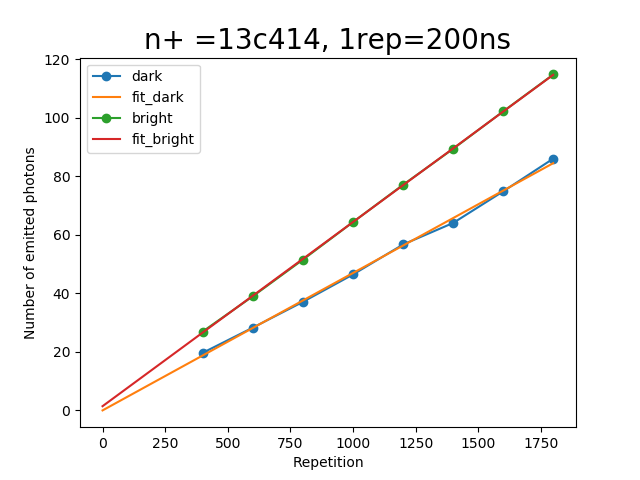

In [9]:
df_sub=df.loc[df.state_result=='n+']

def line(x, a, b): return a*x+b
dark, bright = [], []
N = range(400,2000,200)
#ind_m=95
for n in N:
    stds = np.array([])
    inds = np.array([])
    for ind in df_sub.loc[df_sub.ssr_reps==n].index: # finding the best trace
        d = np.array(df_sub.trace[ind])[::2]-np.array(df_sub.trace[ind])[1::2]
        stds = np.append(stds, np.std(d))
        inds = np.append(inds, ind)
    ind_m = inds[np.argmax(stds)]
    #ind_m+=1
    #print(ind_m)
    d = np.array(df_sub.trace[ind_m])[::2]-np.array(df_sub.trace[ind_m])[1::2] # this is the best trace
    mask_bright, mask_dark=[],[]
    for m in d>0: 
        mask_bright +=[m, not(m)]
        mask_dark   +=[not(m), m]
        
    bright.append(np.mean(np.array(df_sub.trace[ind_m])[mask_bright]))
    dark.append(np.mean(np.array(df_sub.trace[ind_m])[mask_dark]))

popt_d, pcov_d = curve_fit(line, N, dark)
popt_b, pcov_b = curve_fit(line, N, bright)
u1_np, u2_np = popt_d[0], popt_b[0]
print('lambda2={} photon/rep,'.format(u2_np)+' error={},'.format(np.sqrt(np.diag(pcov_b)[0])))
print('lambda1={} photon/rep,'.format(u1_np)+' error={},'.format(np.sqrt(np.diag(pcov_d)[0])))
x_fit=np.arange(1800)
plt.figure()
plt.title('n+ =13c414, 1rep=200ns',fontsize=20)
plt.plot(N, dark,'-o', label='dark')
plt.plot(x_fit, line(x_fit,popt_d[0],popt_d[1]),label='fit_dark')
plt.plot(N, bright,'-o', label='bright')
plt.plot(x_fit, line(x_fit,popt_b[0],popt_b[1]),label='fit_bright')
plt.xlabel('Repetition')
plt.ylabel('Number of emitted photons')
plt.legend()

lambda2=0.0671986847206 photon/rep, error=0.000700208754299,
lambda1=0.0524255293854 photon/rep, error=0.00193937747745,


<IPython.core.display.Javascript object>


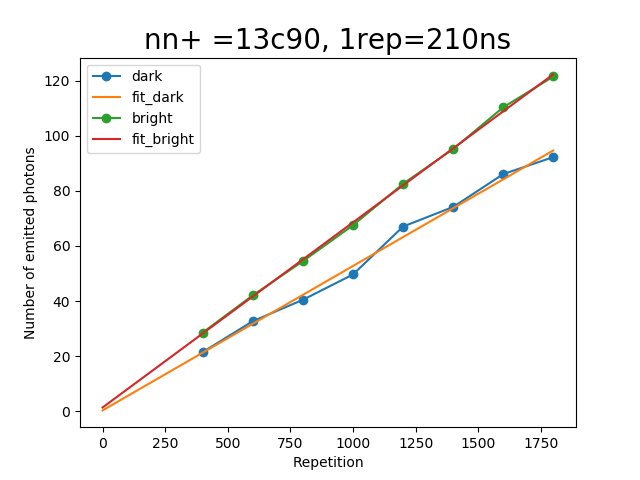

In [10]:
df_sub=df.loc[df.state_result=='nn+']

def line(x, a, b): return a*x+b
dark, bright = [], []
N = range(400,2000,200)
#ind_m=95
for n in N:
    stds = np.array([])
    inds = np.array([])
    for ind in df_sub.loc[df_sub.ssr_reps==n].index: # finding the best trace
        d = np.array(df_sub.trace[ind])[::2]-np.array(df_sub.trace[ind])[1::2]
        stds = np.append(stds, np.std(d))
        inds = np.append(inds, ind)
    ind_m = inds[np.argmax(stds)]
    #ind_m+=1
    #print(ind_m)
    d = np.array(df_sub.trace[ind_m])[::2]-np.array(df_sub.trace[ind_m])[1::2] # this is the best trace
    mask_bright, mask_dark=[],[]
    for m in d>0: 
        mask_bright +=[m, not(m)]
        mask_dark   +=[not(m), m]
        
    bright.append(np.mean(np.array(df_sub.trace[ind_m])[mask_bright]))
    dark.append(np.mean(np.array(df_sub.trace[ind_m])[mask_dark]))

popt_d, pcov_d = curve_fit(line, N, dark)
popt_b, pcov_b = curve_fit(line, N, bright)
u1_npp, u2_npp = popt_d[0], popt_b[0]
print('lambda2={} photon/rep,'.format(u2_npp)+' error={},'.format(np.sqrt(np.diag(pcov_b)[0])))
print('lambda1={} photon/rep,'.format(u1_npp)+' error={},'.format(np.sqrt(np.diag(pcov_d)[0])))
x_fit=np.arange(1800)
plt.figure()
plt.title('nn+ =13c90, 1rep=210ns',fontsize=20)
plt.plot(N, dark,'-o', label='dark')
plt.plot(x_fit, line(x_fit,popt_d[0],popt_d[1]),label='fit_dark')
plt.plot(N, bright,'-o', label='bright')
plt.plot(x_fit, line(x_fit,popt_b[0],popt_b[1]),label='fit_bright')
plt.xlabel('Repetition')
plt.ylabel('Number of emitted photons')
plt.legend()

lambda2=0.0554523111177 photon/rep, error=0.000279397095267,
lambda1=0.0408401657834 photon/rep, error=0.000796474570967,


<IPython.core.display.Javascript object>


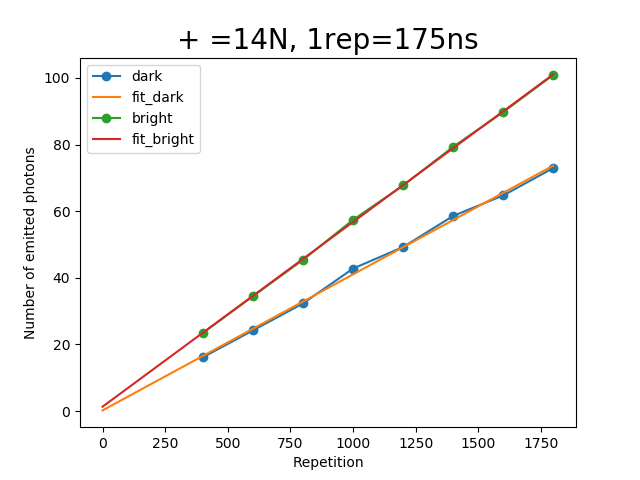

In [11]:
df_sub=df.loc[df.state_result=='+']

def line(x, a, b): return a*x+b
dark, bright = [], []
N = range(400,2000,200)
#ind_m=95
for n in N:
    stds = np.array([])
    inds = np.array([])
    for ind in df_sub.loc[df_sub.ssr_reps==n].index: # finding the best trace
        d = np.array(df_sub.trace[ind])[::2]-np.array(df_sub.trace[ind])[1::2]
        stds = np.append(stds, np.std(d))
        inds = np.append(inds, ind)
    ind_m = inds[np.argmax(stds)]
    #ind_m+=1
    #print(ind_m)
    d = np.array(df_sub.trace[ind_m])[::2]-np.array(df_sub.trace[ind_m])[1::2] # this is the best trace
    mask_bright, mask_dark=[],[]
    for m in d>0: 
        mask_bright +=[m, not(m)]
        mask_dark   +=[not(m), m]
        
    bright.append(np.mean(np.array(df_sub.trace[ind_m])[mask_bright]))
    dark.append(np.mean(np.array(df_sub.trace[ind_m])[mask_dark]))

popt_d, pcov_d = curve_fit(line, N, dark)
popt_b, pcov_b = curve_fit(line, N, bright)
u1_p, u2_p = popt_d[0], popt_b[0]
print('lambda2={} photon/rep,'.format(u2_p)+' error={},'.format(np.sqrt(np.diag(pcov_b)[0])))
print('lambda1={} photon/rep,'.format(u1_p)+' error={},'.format(np.sqrt(np.diag(pcov_d)[0])))
x_fit=np.arange(1800)
plt.figure()
plt.title('+ =14N, 1rep=175ns',fontsize=20)
plt.plot(N, dark,'-o', label='dark')
plt.plot(x_fit, line(x_fit,popt_d[0],popt_d[1]),label='fit_dark')
plt.plot(N, bright,'-o', label='bright')
plt.plot(x_fit, line(x_fit,popt_b[0],popt_b[1]),label='fit_bright')
plt.xlabel('Repetition')
plt.ylabel('Number of emitted photons')
plt.legend()

<IPython.core.display.Javascript object>


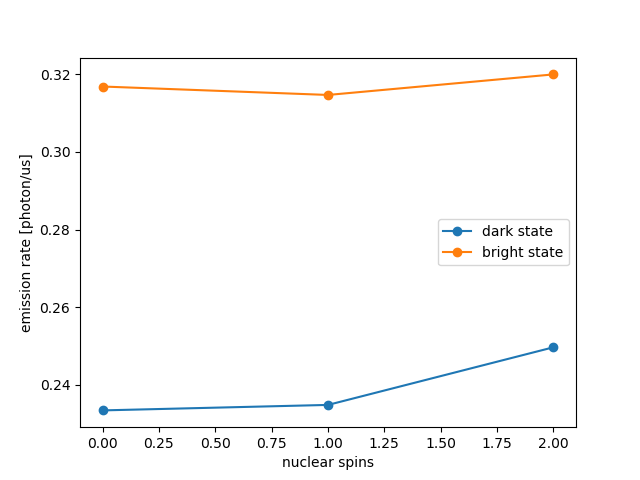

In [16]:
# Photon rate should be constant
plt.figure()
plt.plot([u1_p/0.175, u1_np/0.200, u1_npp/0.210], '-o', label='dark state')
plt.plot([u2_p/0.175, u2_np/0.200, u2_npp/0.210], '-o', label='bright state')
plt.xlabel('nuclear spins')
plt.ylabel('emission rate [photon/us]')
plt.legend()

# Let's fix which nuclear spin, and ssr repetition you are looking at

In [115]:
tR = 1800
df_sub=df.loc[df.state_result=='n+'].loc[df.ssr_reps==tR]
df_sub

,sweeps,rabi_period,state_result,ms,ddt,n_rep_dd,ssr_reps,result_0,result_1,trace,events,thresholds,start_time,end_time,local_oscillator_freq,confocal_x,confocal_y,confocal_z
7,0,0.1,n+,-1,hahn,1,1800,0.481481,NaN,"[116, 116, 116, 107, 122, 130, 118, 113, 116, ...",81,[0],2020-02-03 16:46:14.694,2020-02-03 16:46:27.068,15594.884444,50.859073,46.89,13.7075
31,1,0.1,n+,-1,hahn,1,1800,0.378788,NaN,"[114, 102, 89, 77, 101, 99, 124, 64, 136, 75, ...",66,[0],2020-02-03 17:06:48.863,2020-02-03 17:07:01.507,15594.589580,50.859073,46.89,13.7075
55,2,0.1,n+,-1,hahn,1,1800,0.487805,NaN,"[122, 94, 123, 126, 117, 116, 107, 103, 123, 1...",82,[0],2020-02-03 17:25:28.415,2020-02-03 17:25:40.738,15594.732067,50.859073,46.89,13.7075
79,3,0.1,n+,-1,hahn,1,1800,0.902367,NaN,"[100, 92, 114, 78, 101, 108, 121, 117, 110, 11...",338,[0],2020-02-03 17:45:26.414,2020-02-03 17:45:38.824,15595.752033,50.859073,46.89,13.7075
103,4,0.1,n+,-1,hahn,1,1800,0.882979,NaN,"[73, 97, 68, 127, 78, 115, 74, 106, 65, 106, 7...",282,[0],2020-02-03 18:05:22.735,2020-02-03 18:05:35.083,15595.661618,50.859073,46.89,13.7075


# Evaluate the quality of your data

<IPython.core.display.Javascript object>


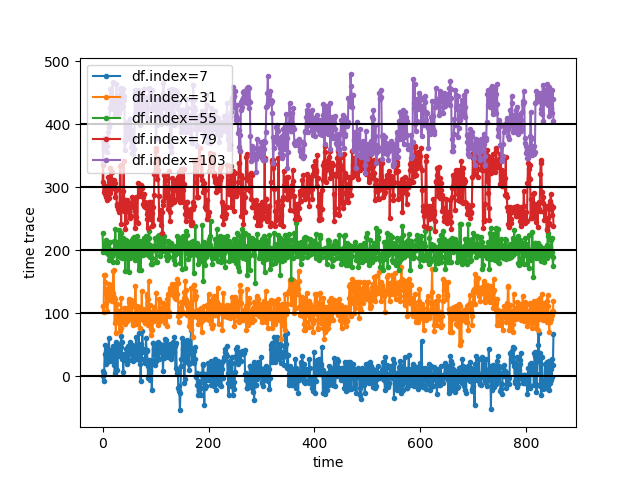

std = 22.5519730246
(7L, 34.859154929577464)
std = 21.7658040496
(31L, 33.33333333333333)
std = 14.8807377243
(55L, 45.305164319248824)
std = 33.2081578946
(79L, 55.16431924882629)
std = 33.0777296447
(103L, 48.00469483568075)


<IPython.core.display.Javascript object>


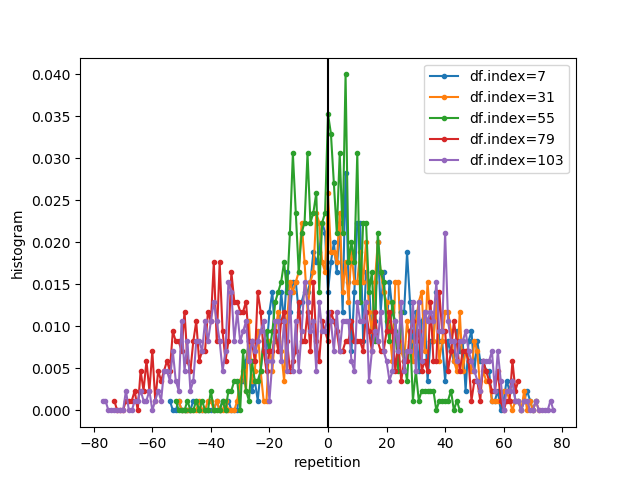

In [116]:
%matplotlib notebook
all_d = np.array([])
plt.figure()
clarity_shift = 0
for ind in df_sub.index:
    #d = np.array(df_sub.trace[ind])
    d = np.array(df_sub.trace[ind])[::2]-np.array(df_sub.trace[ind])[1::2]
    all_d = np.append(all_d,d)
    d = d[:]
    print('std = {}'.format(np.std(d)))
    #hist,bins = np.histogram(a=d,bins=np.arange(d.min(),d.max(),1),density=True)
    print(ind, len(d[d<0])/len(d)*100)
    plt.plot(d+np.ones_like(d,dtype=float)*clarity_shift, 'o-',ms=3, label = 'df.index={}'.format(ind))
    plt.axhline(y=clarity_shift, color='black')
    clarity_shift +=100

plt.ylabel('time trace')
plt.xlabel('time')
plt.legend()

all_d = np.array([])
plt.figure()
for ind in df_sub.index:
    #d = np.array(df_sub.trace[ind])
    d = np.array(df_sub.trace[ind])[::2]-np.array(df_sub.trace[ind])[1::2]
    all_d = np.append(all_d,d)
    d = d[:]
    hist,bins = np.histogram(a=d,bins=np.arange(d.min(),d.max(),1),density=True)
    #print(bins.shape)
    plt.plot(bins[:-1],hist, 'o-',ms=3, label = 'df.index={}'.format(ind))
plt.axvline(x=0, color='black')
plt.ylabel('histogram')
plt.xlabel('repetition')
plt.legend()

# correlation method for calculating gammas:
## gamma1+gamma2 = decay
## gamma1/gamma2 = population2/population1

<IPython.core.display.Javascript object>


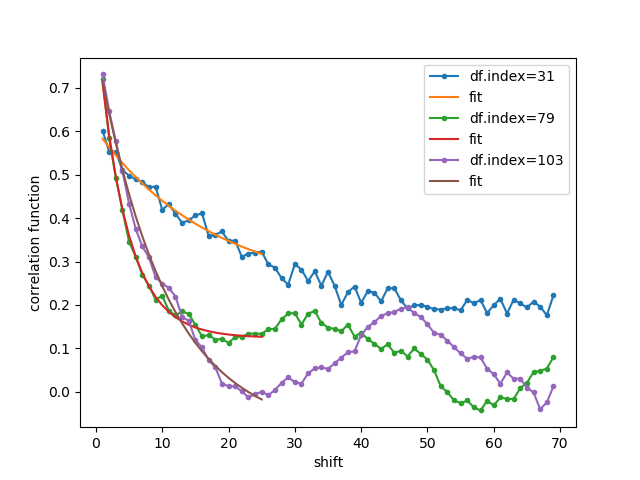

100%|██████████| 69/69 [00:00<00:00, 896.10it/s]


(31L,)
index=31, gamma1+gamma2=0.0569636723944 photon/tR, error=0.012161620146,
gamma1=4.15790509577e-05 photon/rep, gamma2=3.92744384335e-05 photon/rep,


100%|██████████| 69/69 [00:00<00:00, 633.03it/s]


(79L,)
index=79, gamma1+gamma2=0.228165432075 photon/tR, error=0.00830119167815,
gamma1=4.15790509577e-05 photon/rep, gamma2=3.92744384335e-05 photon/rep,


100%|██████████| 69/69 [00:00<00:00, 1131.15it/s]


(103L,)
index=103, gamma1+gamma2=0.0964569722554 photon/tR, error=0.0060174195971,
gamma1=4.15790509577e-05 photon/rep, gamma2=3.92744384335e-05 photon/rep,


(2.7557316565450727e-05, 2.6029890243116283e-05)

In [118]:
from tqdm import tqdm
from __future__ import division
%matplotlib notebook

plt.figure()
gammas1 = []
gammas2 = []
for ind in df_sub.index:
    if ind==55 or ind==7: continue #### SKIP your bad data here
    arr = np.array(df_sub.trace[ind])[::2]-np.array(df_sub.trace[ind])[1::2]
    corr_arr =np.array([])
    K = np.arange(1,70)
    for k in tqdm(K):
        corr, norm = 0, 0
        for j in range(len(arr)-k):
            corr += arr[j]*arr[j+k]
            norm += arr[j]*arr[j]
        
        corr = corr/norm
        corr_arr = np.append(corr_arr, corr)
    plt.plot(K, corr_arr, 'o-',ms=3, label = 'df.index={}'.format(ind))
    def exp_decay(x, a,b,c): return a*np.exp(-b*x)+c
    n0=25
    xdata = K[:n0]
    ydata = corr_arr[:n0]
    popt, pcov = curve_fit(exp_decay, xdata, ydata)
    p2, p1 = len(arr[arr>0])/len(arr)*100, len(arr[arr<0])/len(arr)*100
    gammas1.append((p2*popt[1]/tR)/(p1+p2))
    gammas2.append((p1*popt[1]/tR)/(p1+p2))
    print(ind, )
    print('index={},'.format(ind)+' gamma1+gamma2={} photon/tR,'.format(popt[1])+' error={},'.format(np.sqrt(pcov[1][1])))
    print('gamma1={} photon/rep,'.format(gamma1)+' gamma2={} photon/rep,'.format(gamma2))
    plt.plot(xdata, exp_decay(xdata, popt[0],popt[1],popt[2]), label='fit')


plt.ylabel('correlation function')
#plt.yscale('log')
plt.xlabel('shift')
plt.legend()
gamma1, gamma2 = gammas1[-1],gammas2[-1]
gamma1, gamma2

# Fitting to photon distribution

# Let's extract good data for a better fit!

<IPython.core.display.Javascript object>


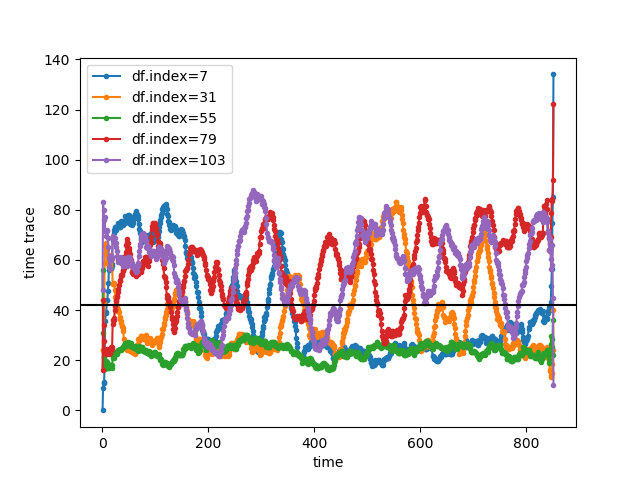

<IPython.core.display.Javascript object>


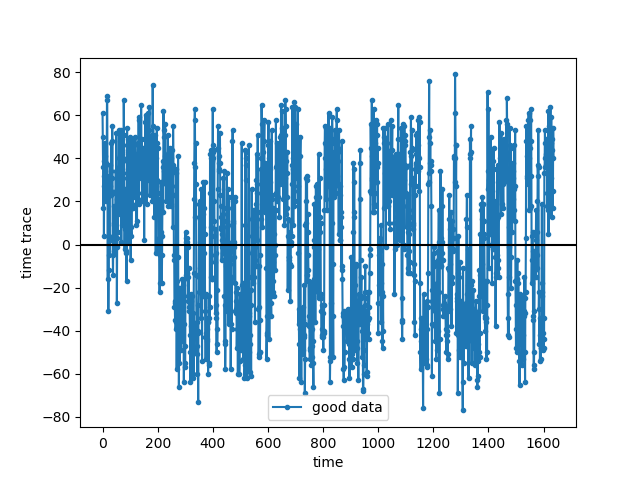

C:\Users\majid\Anaconda2\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater
C:\Users\majid\Anaconda2\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater


In [120]:
interval=20 # evaluate each point with 10 point before and after
filtering_thresh = 42
plt.figure()
for ind in df_sub.index:
    #if ind==37 or ind==61: continue
    d = np.array(df_sub.trace[ind])[::2]-np.array(df_sub.trace[ind])[1::2]
    evaluation=np.array([])
    for i, value in enumerate(d):
        if i+interval >= len(d): vector = d[i:]
        elif i-interval < 0:     vector = d[:i]
        else:                    vector = d[i-interval:i+interval]
        point_evaluation =np.array([])
        for v in vector: point_evaluation = np.append(point_evaluation, abs(2*v))
        evaluation = np.append(evaluation, np.mean(point_evaluation))
    plt.plot(evaluation, 'o-',ms=3, label = 'df.index={}'.format(ind)) 
        

plt.axhline(y=filtering_thresh, color='black')
plt.ylabel('time trace')
plt.xlabel('time')
plt.legend()
########################################################################################

plt.figure()
good_data =np.array([])
all_data = np.array([])
good_d = np.array([])
for ind in df_sub.index:
    if ind==55 or ind==7: continue
    d = np.array(df_sub.trace[ind])[::2]-np.array(df_sub.trace[ind])[1::2]
    evaluation=np.array([])
    for i, value in enumerate(d):
        if i+interval >= len(d): vector = d[i:]
        elif i-interval < 0:     vector = d[:i]
        else:                    vector = d[i-interval:i+interval]
        point_evaluation =np.array([])
        for v in vector: point_evaluation = np.append(point_evaluation, abs(2*v))
        evaluation = np.append(evaluation, np.mean(point_evaluation))
    mask = []
    for m in evaluation>filtering_thresh:
        mask +=[m , m]
    d = np.array(df_sub.trace[ind])[::2]-np.array(df_sub.trace[ind])[1::2]
    good_d = np.append(good_d, d[evaluation>filtering_thresh])
    good_data = np.append(good_data, np.array(df_sub.trace[ind])[mask])
    all_data = np.append(all_data, np.array(df_sub.trace[ind]))
    #plt.plot(evaluation, 'o-',ms=3, label = 'df.index={}'.format(ind)) 
     
        
plt.plot(good_d, 'o-',ms=3, label = 'good data')
plt.axhline(y=0, color='black')
plt.ylabel('time trace')
plt.xlabel('time')
plt.legend()                    

<IPython.core.display.Javascript object>


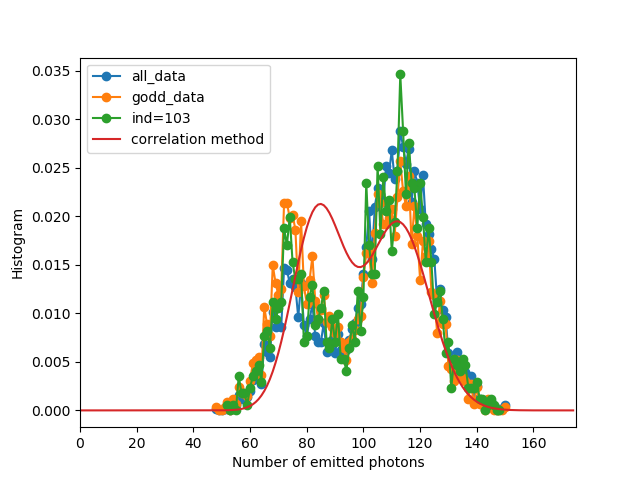

In [122]:
### Let's see good data, all data, and how is the distribution according to correlation method
plt.figure()

d = all_data
hist, bins = np.histogram(a=d,bins=np.arange(d.min(),d.max(),1),density=True)
plt.plot(bins[:-1],hist,'-o', label = 'all_data')

d = good_data
hist, bins = np.histogram(a=d,bins=np.arange(d.min(),d.max(),1),density=True)
plt.plot(bins[:-1],hist,'-o', label = 'godd_data')

ind=103
d = np.array(df_sub.trace[ind])
hist, bins = np.histogram(a=d,bins=np.arange(d.min(),d.max(),1),density=True)
plt.plot(bins[:-1],hist,'-o', label = 'ind={}'.format(ind))


para = [gamma1,gamma2,u1_np,u2_np]
gamma1,gamma2,u1_np,u2_np = para
P=[]
histdata_x = np.arange(0,175,1)
for n in histdata_x:   
    pn=prob_total(n,tR,gamma1,gamma2,u1_np,u2_np)
    P.append(pn)

plt.plot(histdata_x,P,'-',label='correlation method')
#plt.yscale('log')
plt.xlabel('Number of emitted photons')
plt.ylabel('Histogram')
plt.xlim([0, 175])
plt.legend()

g0,g1,u0,u1= [6.76736168e-09 2.79513976e-09 4.30091481e-02 6.29057886e-02],


C:\Users\majid\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


error g0,g1,u0,u1= [1.69799861e-04 7.01329511e-05 4.13636895e-04 3.27047401e-04],


<IPython.core.display.Javascript object>


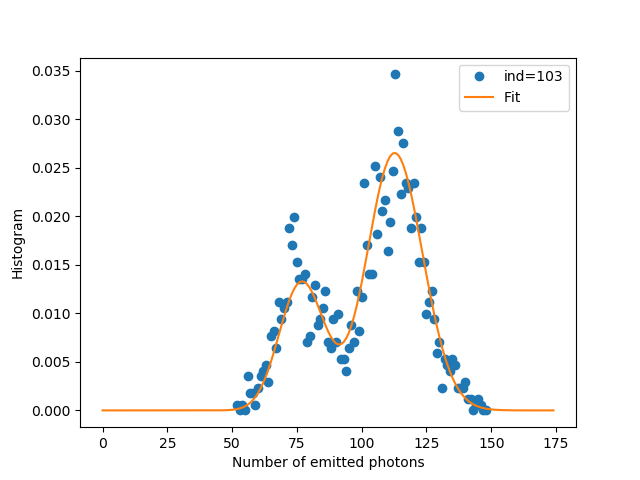

In [123]:
### fit to good trace
#ind=96
d = np.array(df_sub.trace[ind])
hist, bins = np.histogram(a=d,bins=np.arange(d.min(),d.max(),1),density=True)

para0 = [gamma1,gamma2,u1_np,u2_np]
para, paracov = fitPhotonStat(bins[:-1][hist!=0], hist[hist!=0],tR, para0[0],para0[1],para0[2],para0[3])
print('g0,g1,u0,u1= {},'.format(para))
print('error g0,g1,u0,u1= {},'.format(np.diag(np.sqrt(paracov))))
g1_trace,g2_trace,u1_trace,u2_trace = para
P=[]
histdata_x = np.arange(0,175,1)
for n in histdata_x:   
    pn=prob_total(n,tR,g1_trace,g2_trace,u1_trace,u2_trace)
    P.append(pn)
plt.figure()
plt.plot(bins[:-1],hist,'o', label = 'ind={}'.format(ind))
plt.plot(histdata_x,P,'-',label='Fit')
#plt.yscale('log')
plt.xlabel('Number of emitted photons')
plt.ylabel('Histogram')
plt.legend()

g0,g1,u0,u1= [4.60856368e-09 2.73847236e-09 4.23202964e-02 6.23841136e-02],


C:\Users\majid\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


error g0,g1,u0,u1= [1.26406112e-04 7.51123452e-05 2.83492734e-04 2.47023328e-04],


<IPython.core.display.Javascript object>


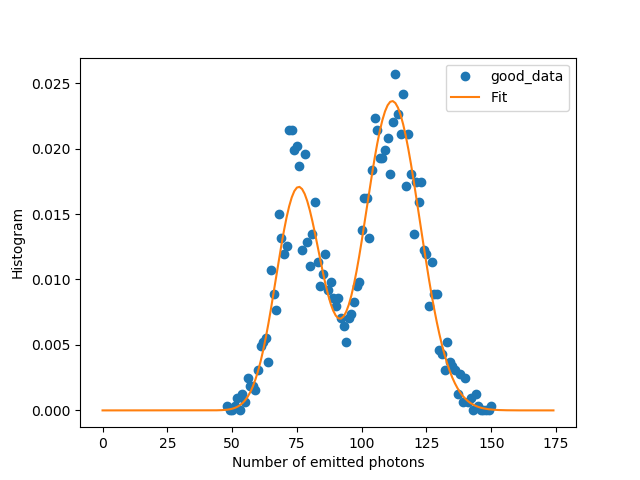

In [124]:
### fit to good data

d = good_data
hist, bins = np.histogram(a=d,bins=np.arange(d.min(),d.max(),1),density=True)

para = [gamma1,gamma2,u1_np,u2_np]
para, paracov = fitPhotonStat(bins[:-1][hist!=0], hist[hist!=0],tR, para[0],para[1],para[2],para[3])
print('g0,g1,u0,u1= {},'.format(para))
print('error g0,g1,u0,u1= {},'.format(np.diag(np.sqrt(paracov))))
g1_good,g2_good,u1_good,u2_good = para
P=[]
histdata_x = np.arange(0,175,1)
for n in histdata_x: 
    pn=prob_total(n,tR,g1_good,g2_good,u1_good,u2_good)
    P.append(pn)
plt.figure()
plt.plot(bins[:-1],hist,'o', label = 'good_data')
plt.plot(histdata_x,P,'-',label='Fit')
#plt.yscale('log')
plt.xlabel('Number of emitted photons')
plt.ylabel('Histogram')
plt.legend()

g0,g1,u0,u1= [7.88054121e-09 2.60188339e-09 4.20032435e-02 6.22195758e-02],


C:\Users\majid\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


error g0,g1,u0,u1= [1.38288817e-04 4.56582814e-05 3.34189432e-04 1.98132748e-04],


<IPython.core.display.Javascript object>


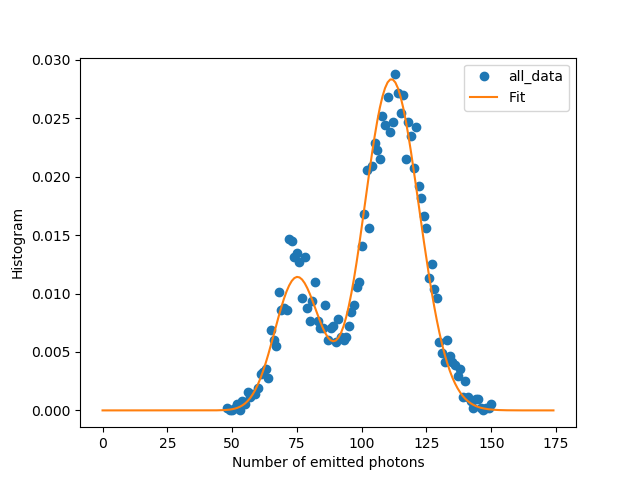

In [125]:
### fit to all data

d = all_data
hist, bins = np.histogram(a=d,bins=np.arange(d.min(),d.max(),1),density=True)

para = [gamma1,gamma2,u1_np,u2_np]
para, paracov = fitPhotonStat(bins[:-1][hist!=0], hist[hist!=0],tR, para[0],para[1],para[2],para[3])
print('g0,g1,u0,u1= {},'.format(para))
print('error g0,g1,u0,u1= {},'.format(np.diag(np.sqrt(paracov))))
g1_all,g2_all,u1_all,u2_all = para
P=[]
histdata_x = np.arange(0,175,1)
for n in histdata_x: 
    pn=prob_total(n,tR,g1_all,g2_all,u1_all,u2_all)
    P.append(pn)
plt.figure()
plt.plot(bins[:-1],hist,'o', label = 'all_data')
plt.plot(histdata_x,P,'-',label='Fit')
#plt.yscale('log')
plt.xlabel('Number of emitted photons')
plt.ylabel('Histogram')
plt.legend()

# Gamma as a function of repetitions

In [126]:
G1_corr.append(gamma1)
G2_corr.append(gamma2)
G1_good_data.append(g1_good)
G2_good_data.append(g2_good)
G1_good_trace.append(g1_trace)
G2_good_trace.append(g2_trace)
G1_all_data.append(g1_all)
G2_all_data.append(g2_all)

<IPython.core.display.Javascript object>


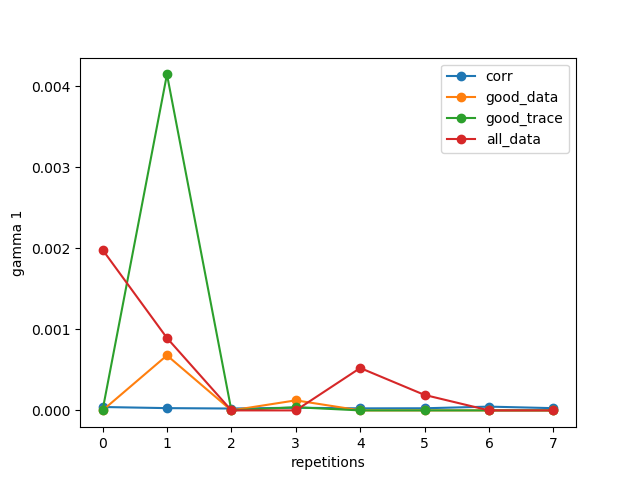

<IPython.core.display.Javascript object>


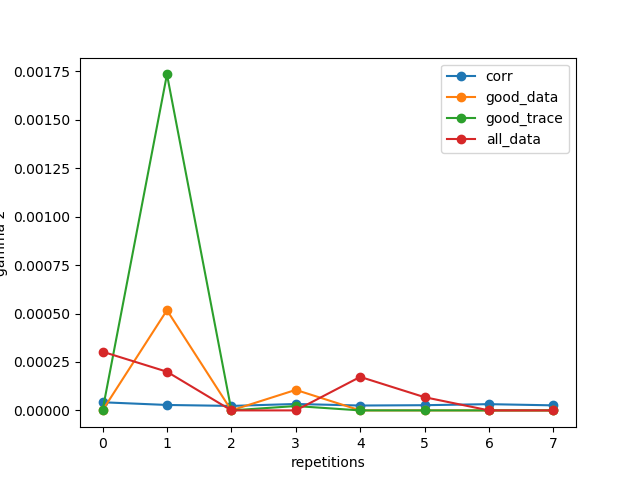

In [127]:
plt.figure()
plt.plot(G1_corr, '-o', label='corr')
plt.plot(G1_good_data, '-o', label='good_data')
plt.plot(G1_good_trace, '-o', label='good_trace')
plt.plot(G1_all_data, '-o', label='all_data')

plt.xlabel('repetitions')
plt.ylabel('gamma 1')
plt.legend()

plt.figure()
plt.plot(G2_corr, '-o', label='corr')
plt.plot(G2_good_data, '-o', label='good_data')
plt.plot(G2_good_trace, '-o', label='good_trace')
plt.plot(G2_all_data, '-o', label='all_data')
plt.xlabel('repetitions')
plt.ylabel('gamma 2')
plt.legend()

<IPython.core.display.Javascript object>


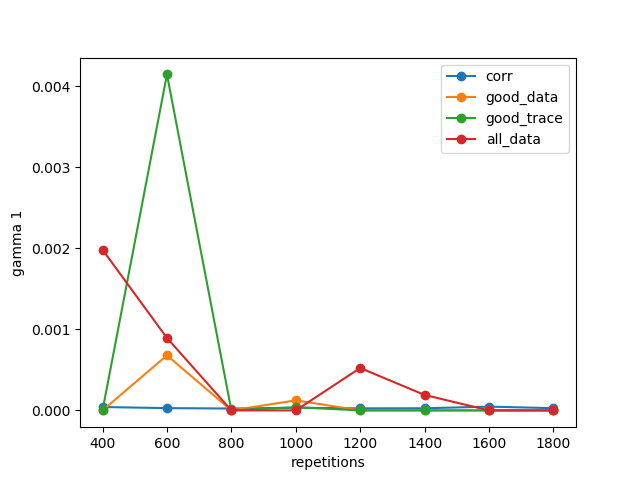

<IPython.core.display.Javascript object>


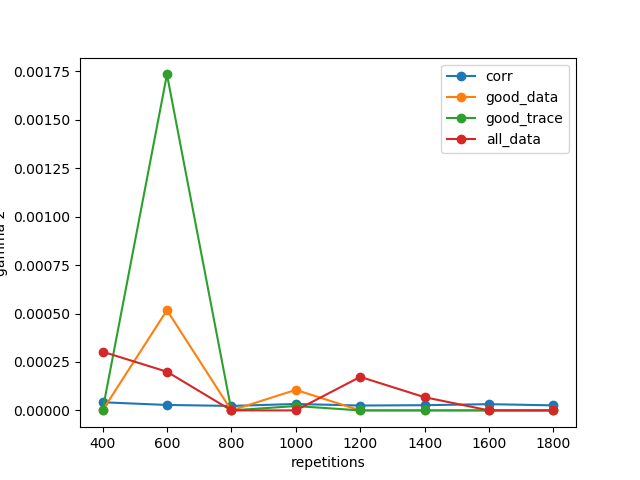

In [129]:
plt.figure()
plt.plot(N, G1_corr, '-o', label='corr')
plt.plot(N, G1_good_data, '-o', label='good_data')
plt.plot(N, G1_good_trace, '-o', label='good_trace')
plt.plot(N, G1_all_data, '-o', label='all_data')

plt.xlabel('repetitions')
plt.ylabel('gamma 1')
plt.legend()

plt.figure()
plt.plot(N, G2_corr, '-o', label='corr')
plt.plot(N, G2_good_data, '-o', label='good_data')
plt.plot(N, G2_good_trace, '-o', label='good_trace')
plt.plot(N, G2_all_data, '-o', label='all_data')

plt.xlabel('repetitions')
plt.ylabel('gamma 2')
plt.legend()

In [32]:
N = range(400,2000,200)
G1_corr =[]
G2_corr =[]
G1_good_data =[]
G2_good_data =[]
G1_good_trace =[]
G2_good_trace =[]
G1_all_data =[]
G2_all_data =[]